# BDI intenship pre-interview exercise

Brief analysis of clusters in comorbidity network of symptoms and diseases reported over a three month period by approximately 16,000 individuals aged 1+ years in 17 villages of Mayuge District, Uganda. This is a region with a high risk of schistosome infection. Understanding common symptom/disease comorbidities in the region can assist with identifying an irregular symptom profile. Common symptoms experienced by patients with schistosome infections include diarrhoea, abdominal discomfort and vomiting blood. 

The data for this analysis was taken from Chami, G. F., Kabatereine, N. B., Tukahebwa, E. M., & Dunne, D. W. (2018) 'Precision global health and comorbidity: a population-based study of 16 357 people in rural Uganda', *Journal of the Royal Society Interface*, 15(147), 20180248. https://doi.org/10.1098/rsif.2018.0248.

## Network construction

In [1]:
# Construct the symptom network

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyvis.network import Network
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import itertools

# import data
df = pd.read_csv('symptom_edgelist.csv')
Graphtype = nx.Graph()

G = nx.from_pandas_edgelist(df, 'node 1', 'node 2', edge_attr='weight', create_using=Graphtype)

## Basic statistics and measures

In [2]:
# Some basic statistics
num_nodes = nx.number_of_nodes(G)
num_edges = nx.number_of_edges(G)
density = nx.density(G)

# number of connected components
num_components = nx.number_connected_components(G)

# largest connected component
largest_cc = max(nx.connected_components(G), key=len)
C = G.subgraph(largest_cc).copy()

# basic details for largest connected component
num_nodes_c = nx.number_of_nodes(C)
num_edges_c = nx.number_of_edges(C)
density_c = nx.density(C)

# node centrality measures for largest connected component
def get_top_keys(dictionary, top):
    items = list(dictionary.items())
    items.sort(reverse=True, key=lambda x: x[1])
    return list(map(lambda x: x[0], items[:top]))

# centrality
bet_cen = nx.betweenness_centrality(C)
clo_cen = nx.closeness_centrality(C)
eig_cen = nx.eigenvector_centrality(C)

# most central nodes
most_bet_cen = get_top_keys(bet_cen, 5)
most_clo_cen = get_top_keys(clo_cen, 5)
most_eig_cen = get_top_keys(eig_cen, 5)


print(f"Nodes: {num_nodes}, Edges: {num_edges}, Density: {density}, Componenents: {num_components}")
print("Largest connected component details:")
print(f"Nodes: {num_nodes_c}, Edges: {num_edges_c}, Density: {density_c}")

print(f"Most central nodes. Betweeness: {most_bet_cen}, closeness: {most_clo_cen}, eigenvector: {most_eig_cen}.")

Nodes: 79, Edges: 140, Density: 0.04543979227523531, Componenents: 5
Largest connected component details:
Nodes: 71, Edges: 136, Density: 0.05472837022132797
Most central nodes. Betweeness: ['sexually transmitted infection', 'back pain', 'loss of appetite', 'wheezing', 'nose bleeds'], closeness: ['sexually transmitted infection', 'loss of appetite', 'wheezing', 'itchy rash', 'fever'], eigenvector: ['loss of appetite', 'cough', 'wheezing', 'itchy rash', 'fever'].


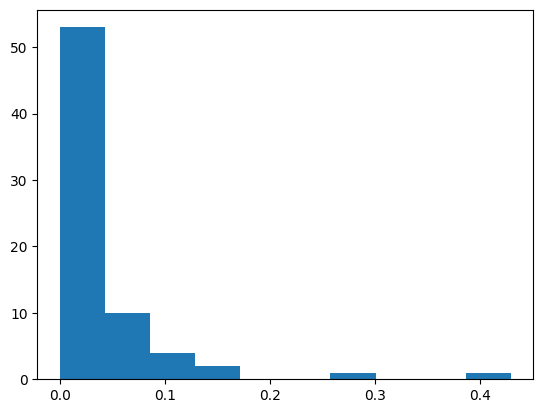

In [3]:
# centrality distribution betweenness

plt.hist(list(bet_cen.values()))
plt.show()

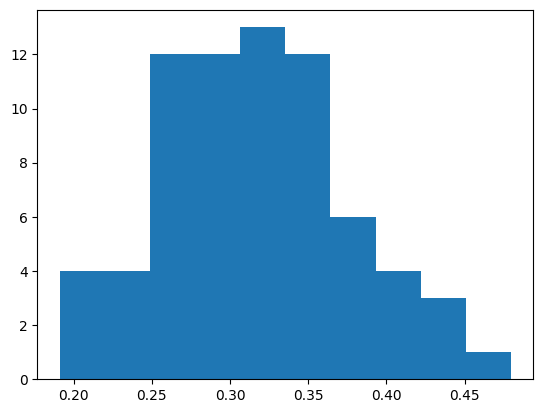

In [4]:
# centrality distribution closeness

plt.hist(list(clo_cen.values()))
plt.show()

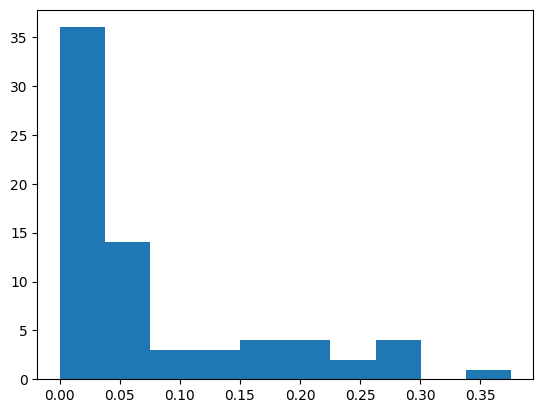

In [5]:
# centrality distribution eigenvector
plt.hist(list(eig_cen.values()))
plt.show()

## Graph interpretation

### Largest connected component

All connected components but the largest are trivial, containing only two nodes and one edge. All further analyses and clustering will only be done on the largest connected component.

In [6]:
# number of nodes in each of the connected components:

[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[71, 2, 2, 2, 2]

### Non-scale free degree distribution
There is no strong evidence suggesting that the power-law fits better than the log-normal or vice-versa, but the negative log-likelihood ratio indicates that the log-normal distribution fits the data a little better than the power-law distribution.

This has some implications on the overall network structure, and clusters detected are likely to be more homogoneous but less well separated.

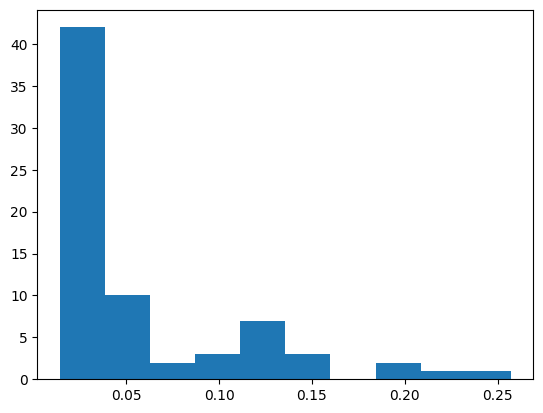

In [7]:
# degree distribution
plt.hist(list(nx.degree_centrality(C).values()))
plt.show()

Calculating best minimal value for power law fit
Log-likelihood ratio: -0.6949827712618817
p-value: 0.16701479724489388


C:\Users\chana\venvs\m269-23j\lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


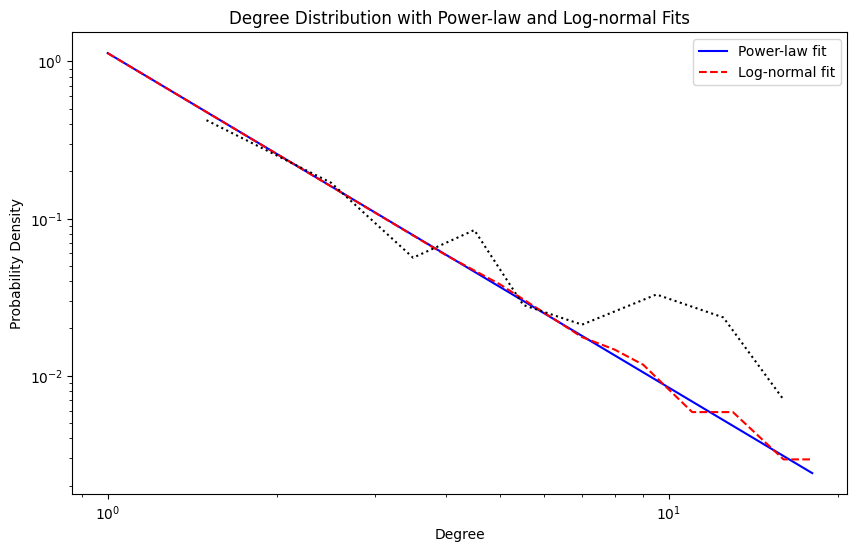

No strong evidence to prefer power-law over log-normal or vice versa.


In [8]:
# check if degree distribution is scale free

import powerlaw

# Calculate degree sequence
degree_sequence = [degree for node, degree in C.degree()]

# Fit the degree distribution to a power-law and log-normal
fit = powerlaw.Fit(degree_sequence)

# Compare power-law and log-normal distributions
R, p = fit.distribution_compare('power_law', 'lognormal')

# Print the results
print(f'Log-likelihood ratio: {R}')
print(f'p-value: {p}')

# Plot the distributions
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
fit.power_law.plot_pdf(color='b', linestyle='-', ax=ax, label='Power-law fit')
fit.lognormal.plot_pdf(color='r', linestyle='--', ax=ax, label='Log-normal fit')
fit.plot_pdf(color='k', linestyle=':', ax=ax)
plt.title('Degree Distribution with Power-law and Log-normal Fits')
plt.xlabel('Degree')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# Interpretation of results
if p < 0.05 and R > 0:
    print("The power-law distribution is a better fit than the log-normal distribution.")
elif p < 0.05 and R < 0:
    print("The log-normal distribution is a better fit than the power-law distribution.")
else:
    print("No strong evidence to prefer power-law over log-normal or vice versa.")


## Community detection

In [9]:
# Community detection using Louvain algorithm

communities = nx.community.louvain_communities(C)

# Mapping community numbers to nodes
comm_num = {}
for n, community in enumerate(communities):
    for node in community:
        comm_num[node] = n

# Visualization with Pyvis
# Calculate node degrees
degrees = dict(C.degree())

# Scale node sizes based on degree
min_size = 5
max_size = 40
if len(degrees) > 1:
    node_sizes = [
        min_size + (max_size - min_size) * (degree - min(degrees.values())) / (max(degrees.values()) - min(degrees.values()))
        for degree in degrees.values()
    ]
else:
    node_sizes = [max_size] * len(degrees)

# Ensure the color mapping corresponds to the labels array
color_map = ['blue', 'yellow', 'green', 'orange', 'magenta', 'red']

# Initialize Pyvis network
net = Network(notebook=True)

# Add nodes and edges to the network
for i, node in enumerate(C.nodes()):
    net.add_node(node, label=str(node), color=color_map[comm_num[node] % len(color_map)], size=node_sizes[i])

for edge in C.edges(data=True):
    net.add_edge(edge[0], edge[1], value=edge[2].get('weight'))

net.show('louvain_communities.html')

louvain_communities.html


## Spectral clustering

In [10]:
# Spectral clustering
from sklearn.preprocessing import normalize

# Matrix creation
adj_matrix = nx.to_numpy_array(C)  # Converts graph to an adjacency matrix
node_list = list(C.nodes())  # List of nodes in the graph

# Normalize the adjacency matrix
adj_matrix_normalized = normalize(adj_matrix, norm='l1', axis=1)

# Spectral Clustering
n_clusters = 6
spectral_clusters = SpectralClustering(affinity='precomputed', assign_labels="discretize", random_state=0, n_clusters=n_clusters).fit_predict(adj_matrix)

# Visualization with Pyvis
# Calculate node degrees
degrees = dict(C.degree())

# Scale node sizes based on degree
min_size = 5
max_size = 40
node_sizes = [min_size + (max_size - min_size) * (degree - min(degrees.values())) / (max(degrees.values()) - min(degrees.values())) for degree in degrees.values()]

# Ensure the color mapping corresponds to the labels array
color_map = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta']

# Initialize Pyvis network
net = Network(notebook=True)

# Add nodes and edges to the network
for i, node in enumerate(C.nodes()):
    net.add_node(node, label=str(node), color=color_map[spectral_clusters[i] % len(color_map)], size=node_sizes[i])

for edge in C.edges(data=True):
    net.add_edge(edge[0], edge[1], value=edge[2]['weight'])
    
net.show('spectral.html')

spectral.html


## Comparison of clusters
Fairly high modularity but extremely low silhouette score and high average conductance indicate that the clusters are internally densely connected, but the separation is poor.

Spectral clustering results in more imbalanced cluster sizes compared to the Louvain algorithm.

In [11]:
# Function to compute conductance for a given cluster
def compute_conductance(graph, cluster):
    internal_edges = graph.subgraph(cluster).size(weight='weight')
    total_edges = sum(graph.degree(node, weight='weight') for node in cluster) / 2
    conductance = internal_edges / total_edges
    return conductance

# Function to compute overlap between clusters using Jaccard index
def compute_overlap(cluster1, cluster2):
    intersection = len(set(cluster1) & set(cluster2))
    union = len(set(cluster1) | set(cluster2))
    overlap = intersection / union
    return overlap

In [12]:
# evaluating louvain communities

# cluster size distribution
comm_sizes = [len(community) for community in communities]
comm_sizes = sorted(comm_sizes)
# modularity
l_modularity = nx.community.modularity(C, communities)

# silhouette score
louvain_labels = [comm_num[node] for node in C.nodes()]
silhouette_avg_louvain = silhouette_score(adj_matrix_normalized, louvain_labels, metric='precomputed')

# Conductance
sum_conductance = 0
for community in communities:
    conductance = compute_conductance(C, community)
    sum_conductance += conductance
avg_conductance = sum_conductance / len(communities)

# Overlap using Jaccard index
sum_overlap = 0
for i in range(len(communities)):
    for j in range(i + 1, len(communities)):
        overlap = compute_overlap(communities[i], communities[j])
        sum_overlap += overlap
avg_overlap = sum_overlap / len(communities)

print("Louvain Communities")
print(f"Modularity: {l_modularity}, silhouette score: {silhouette_avg_louvain}, conductance: {avg_conductance}, overlap: {avg_overlap}, cluster size distribution: {comm_sizes}")

Louvain Communities
Modularity: 0.5255638088120457, silhouette score: -0.9986225997454581, conductance: 0.713980864250923, overlap: 0.0, cluster size distribution: [3, 6, 10, 10, 13, 13, 16]


In [13]:
# evaluating spectral clusters

clusters = {}
for idx, label in enumerate(spectral_clusters):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(node_list[idx])
        
spec_clusters = list(clusters.values())

# cluster size distribution
cluster_sizes = [len(cluster) for cluster in spec_clusters]
cluster_sizes = sorted(cluster_sizes)

# modularity
s_modularity = nx.community.modularity(C, spec_clusters)

# silhouette score
silhouette_avg_spectral = silhouette_score(adj_matrix_normalized, spectral_clusters, metric='precomputed')

# Conductance
sum_conductance = 0
for cluster in spec_clusters:
    conductance = compute_conductance(C, cluster)
    sum_conductance += conductance
avg_conductance = sum_conductance / len(spec_clusters)

# Overlap using Jaccard index
sum_overlap = 0
for i in range(len(spec_clusters)):
    for j in range(i + 1, len(spec_clusters)):
        overlap = compute_overlap(spec_clusters[i], spec_clusters[j])
        sum_overlap += overlap
avg_overlap = sum_overlap / len(spec_clusters)

print('Spectral clusters')
print(f"Modularity: {s_modularity}, silhouette score: {silhouette_avg_spectral}, conductance: {avg_conductance}, overlap: {avg_overlap}, cluster size distribution: {cluster_sizes}")

Spectral clusters
Modularity: 0.4832250518071834, silhouette score: -1.0, conductance: 0.8617736553693272, overlap: 0.0, cluster size distribution: [3, 4, 5, 8, 24, 27]


## Conclusion
All connected components but the largest are trivial, containing only two nodes and one edge. All analyses and clustering was only be done on the largest connected component.

The log-normal distribution fits the data a little better than the power-law distribution, indicating that the network degree distribution is not scale free. As a result, clusters detected are likely to be more homogeneous but less well separated.

As anticipated by the degree distribution, both clustering algorithms produced clusters with fairly high modularity but extremely low silhouette scores and high average conductance, indicating that the clusters are internally densely connected, but the separation is poor.

Common symptoms experienced by patients with schistosome infections include diarrhoea, abdominal discomfort and vomiting blood. Both clustering algorithms placed these three symptoms into different clusters, which could be useful for differentiating patients with schistosome infections from the wider regional population.

